# Gun Violence Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# gun violence data 2013-2018
#df_gun_violence = pd.read_csv('./dataset/gun-violence-data_01-2013_03-2018.csv')
df_gun_violence = pd.read_csv('https://media.githubusercontent.com/media/Cng000/Gun-violence-analysis/master/dataset/gun-violence-data_01-2013_03-2018.csv')

In [3]:
df_income = pd.read_csv('./dataset/ACS_17_1YR_S1901_with_ann.csv',skiprows=1)

In [4]:
# mean annual household income (2016)
#df_income = pd.read_csv('./dataset/2016_mean_income_raw_data.csv', skiprows=2)
#df_income = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/master/dataset/2016_mean_income_raw_data.csv', skiprows=2)

In [5]:
# population estimates
#df_state_populations = pd.read_csv('./dataset/population_estimates.csv', skiprows=1)
df_state_populations = pd.read_csv('https://raw.githubusercontent.com/Cng000/Gun-violence-analysis/master/dataset/population_estimates.csv', skiprows=1)

## Gun Violence Analysis

In [6]:
df_gun_violence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 29 columns):
incident_id                    239677 non-null int64
date                           239677 non-null object
state                          239677 non-null object
city_or_county                 239677 non-null object
address                        223180 non-null object
n_killed                       239677 non-null int64
n_injured                      239677 non-null int64
incident_url                   239677 non-null object
source_url                     239209 non-null object
incident_url_fields_missing    239677 non-null bool
congressional_district         227733 non-null float64
gun_stolen                     140179 non-null object
gun_type                       140226 non-null object
incident_characteristics       239351 non-null object
latitude                       231754 non-null float64
location_description           42089 non-null object
longitude                    

In [7]:
df_gun_violence.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [8]:
df_gun_violence_new = df_gun_violence[['incident_id', 'date', 'state', 'city_or_county', 'n_killed', 'n_injured', 'congressional_district', 'gun_stolen', 'gun_type', 'incident_characteristics', 'n_guns_involved', 'participant_age', 'participant_age_group', 'participant_gender', 'participant_status', 'participant_type', 'state_house_district', 'state_senate_district']]

In [9]:
# extract year from date
# SettingWithCopyWarning????
df_gun_violence_new['year'] = pd.to_numeric(df_gun_violence_new.date.str[0:4], downcast='integer')

/Users/Kenny/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df_gun_violence_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 19 columns):
incident_id                 239677 non-null int64
date                        239677 non-null object
state                       239677 non-null object
city_or_county              239677 non-null object
n_killed                    239677 non-null int64
n_injured                   239677 non-null int64
congressional_district      227733 non-null float64
gun_stolen                  140179 non-null object
gun_type                    140226 non-null object
incident_characteristics    239351 non-null object
n_guns_involved             140226 non-null float64
participant_age             147379 non-null object
participant_age_group       197558 non-null object
participant_gender          203315 non-null object
participant_status          212051 non-null object
participant_type            214814 non-null object
state_house_district        200905 non-null float64
state_senate_district 

In [11]:
df_gun_violence_new.head(10)

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,year
0,461105,2013-01-01,Pennsylvania,Mckeesport,0,4,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN,2013
1,460726,2013-01-01,California,Hawthorne,1,3,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,62.0,35.0,2013
2,478855,2013-01-01,Ohio,Lorain,1,3,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,56.0,13.0,2013
3,478925,2013-01-05,Colorado,Aurora,4,0,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,40.0,28.0,2013
4,478959,2013-01-07,North Carolina,Greensboro,2,2,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,62.0,27.0,2013
5,478948,2013-01-07,Oklahoma,Tulsa,4,0,1.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Hom...",NaN,0::23||1::23||2::33||3::55,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Female||2::Female||3::Female||4:...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,72.0,11.0,2013
6,479363,2013-01-19,New Mexico,Albuquerque,5,0,1.0,0::Unknown||1::Unknown,0::22 LR||1::223 Rem [AR-15],"Shot - Dead (murder, accidental, suicide)||Mas...",2.0,0::51||1::40||2::9||3::5||4::2||5::15,0::Adult 18+||1::Adult 18+||2::Child 0-11||3::...,0::Male||1::Female||2::Male||3::Female||4::Fem...,0::Killed||1::Killed||2::Killed||3::Killed||4:...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,10.0,14.0,2013
7,479374,2013-01-21,Louisiana,New Orleans,0,5,2.0,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,NaN,0::Male||1::Male||2::Male||3::Male||4::Male,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,93.0,5.0,2013
8,479389,2013-01-21,California,Brentwood,0,4,9.0,NaN,NaN,Shot - Wounded/Injured||Drive-by (car to stree...,NaN,NaN,0::Teen 12-17||1::Teen 12-17||2::Teen 12-17||4...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,11.0,7.0,2013
9,492151,2013-01-23,Maryland,Baltimore,1,6,7.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::15,0::Teen 12-17||1::Adult 18+||2::Adult 18+||3::...,0::Male,0::Killed||1::Injured||2::Injured||3::Injured|...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,44.0,2013


#### Top 10 cities/counties by number of incidents

In [12]:
df_gun_violence_new['city_or_county'].value_counts().head(10)

Chicago         10814
Baltimore        3943
Washington       3279
New Orleans      3071
Philadelphia     2963
Saint Louis      2501
Houston          2501
Milwaukee        2487
Jacksonville     2448
Memphis          2386
Name: city_or_county, dtype: int64

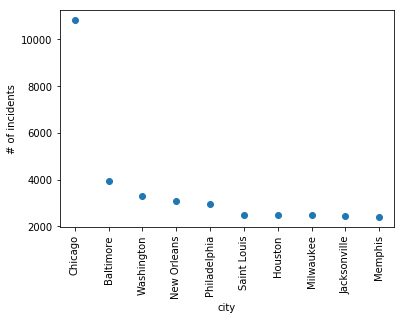

In [13]:
# graph results
y = df_gun_violence_new['city_or_county'].value_counts().index
x = df_gun_violence_new['city_or_county'].value_counts().head(10)
x = list(x)

city = []
for i in range(0,10):
    city.append(y[i])

_ = plt.scatter(x=city, y=x)
_ = plt.xticks(rotation=90)
_ = plt.xlabel("city")
_ = plt.ylabel("# of incidents")
plt.show()

#### Top 10 cities/counties by number of deaths

In [14]:
df_gun_violence_new.groupby('city_or_county')['n_killed'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         2104
Houston         1145
Baltimore       1055
Saint Louis      919
Philadelphia     901
New Orleans      703
Los Angeles      636
Memphis          623
Indianapolis     616
Detroit          604
Name: n_killed, dtype: int64

#### Top 10 cities/counties by number of injured

In [15]:
df_gun_violence_new.groupby('city_or_county')['n_injured'].sum().sort_values(ascending=False).head(10)

city_or_county
Chicago         10427
Baltimore        2427
Philadelphia     2326
New Orleans      1892
Saint Louis      1783
Memphis          1690
Milwaukee        1570
Washington       1439
Columbus         1319
Houston          1255
Name: n_injured, dtype: int64

#### Top 10 states with higher number of incidents

In [16]:
df_gun_violence_new['state'].value_counts().head(10)

Illinois          17556
California        16306
Florida           15029
Texas             13577
Ohio              10244
New York           9712
Pennsylvania       8929
Georgia            8925
North Carolina     8739
Louisiana          8103
Name: state, dtype: int64

#### Top 10 states with higher number of deaths

In [17]:
df_gun_violence_new.groupby('state')['n_killed'].sum().sort_values(ascending=False).head(10)

state
California        5562
Texas             5046
Florida           3909
Illinois          3409
Ohio              2508
Georgia           2456
Pennsylvania      2395
North Carolina    2225
Louisiana         2179
Missouri          2136
Name: n_killed, dtype: int64

#### Top 10 states with higher number of injuries

In [18]:
df_gun_violence_new.groupby('state')['n_injured'].sum().sort_values(ascending=False).head(10)

state
Illinois          13514
California         7644
Florida            7072
Texas              6106
Ohio               5703
New York           5059
Pennsylvania       5056
North Carolina     4629
Tennessee          4478
Louisiana          4398
Name: n_injured, dtype: int64

#### Can we correlate state population to number of violent incidents/deaths?

In [19]:
# let's look at 2013 first
df_gun_violence_2013 = df_gun_violence_new.loc[df_gun_violence_new.year == 2013]['state'].value_counts().reset_index().rename(index=str, columns={'index':'state', 'state':'incident_counts'})
df_gun_violence_2013.head(10)

,state,incident_counts
0,California,39
1,Pennsylvania,20
2,Illinois,18
3,New York,16
4,Michigan,14
5,New Jersey,14
6,Florida,13
7,North Carolina,12
8,Texas,11
9,Ohio,10


In [20]:
# no data for 15 states in 2013. Also, incident counts appear to be too low for 2013
# Let's get the population estimate of each state now

In [21]:
df_state_populations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 13 columns):
Id                                           52 non-null object
Id2                                          52 non-null int64
Geography                                    52 non-null object
April 1, 2010 - Census                       52 non-null int64
April 1, 2010 - Estimates Base               52 non-null int64
Population Estimate (as of July 1) - 2010    52 non-null int64
Population Estimate (as of July 1) - 2011    52 non-null int64
Population Estimate (as of July 1) - 2012    52 non-null int64
Population Estimate (as of July 1) - 2013    52 non-null int64
Population Estimate (as of July 1) - 2014    52 non-null int64
Population Estimate (as of July 1) - 2015    52 non-null int64
Population Estimate (as of July 1) - 2016    52 non-null int64
Population Estimate (as of July 1) - 2017    52 non-null int64
dtypes: int64(11), object(2)
memory usage: 5.4+ KB


In [22]:
df_state_populations.head(10)

,Id,Id2,Geography,"April 1, 2010 - Census","April 1, 2010 - Estimates Base",Population Estimate (as of July 1) - 2010,Population Estimate (as of July 1) - 2011,Population Estimate (as of July 1) - 2012,Population Estimate (as of July 1) - 2013,Population Estimate (as of July 1) - 2014,Population Estimate (as of July 1) - 2015,Population Estimate (as of July 1) - 2016,Population Estimate (as of July 1) - 2017
0,0400000US01,1,Alabama,4779736,4780135,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,0400000US02,2,Alaska,710231,710249,714015,722259,730825,736760,736759,737979,741522,739795
2,0400000US04,4,Arizona,6392017,6392309,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
3,0400000US05,5,Arkansas,2915918,2916031,2921737,2938640,2949208,2956780,2964800,2975626,2988231,3004279
4,0400000US06,6,California,37253956,37254518,37327690,37672654,38019006,38347383,38701278,39032444,39296476,39536653
5,0400000US08,8,Colorado,5029196,5029325,5048029,5116411,5186330,5262556,5342311,5440445,5530105,5607154
6,0400000US09,9,Connecticut,3574097,3574114,3580171,3591927,3597705,3602470,3600188,3593862,3587685,3588184
7,0400000US10,10,Delaware,897934,897936,899712,907884,916868,925114,934805,944107,952698,961939
8,0400000US11,11,District of Columbia,601723,601766,605040,620336,635630,650114,660797,672736,684336,693972
9,0400000US12,12,Florida,18801310,18804594,18846461,19097369,19341327,19584927,19897747,20268567,20656589,20984400


In [23]:
df_state_populations_2013 = df_state_populations[['Geography', 'Population Estimate (as of July 1) - 2013']]

In [24]:
# extract 2013 population estimates
df_state_populations_2013 = df_state_populations_2013.rename(index=str, columns={'Geography':'state', 'Population Estimate (as of July 1) - 2013':'population_estimate'})
df_state_populations_2013.columns

Index(['state', 'population_estimate'], dtype='object')

In [25]:
# merge number of incidents to population estimate (2013 only)
df_incident_population_2013 = df_gun_violence_2013.merge(df_state_populations_2013, how='inner', on='state')
df_incident_population_2013.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 3 columns):
state                  37 non-null object
incident_counts        37 non-null int64
population_estimate    37 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [26]:
df_incident_population_2013.head(10)

,state,incident_counts,population_estimate
0,California,39,38347383
1,Pennsylvania,20,12778450
2,Illinois,18,12890403
3,New York,16,19712514
4,Michigan,14,9899219
5,New Jersey,14,8913735
6,Florida,13,19584927
7,North Carolina,12,9849812
8,Texas,11,26479279
9,Ohio,10,11567845


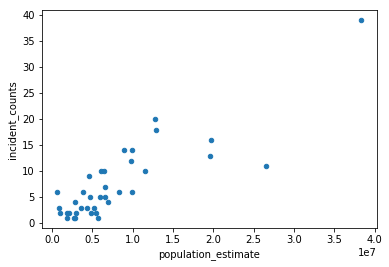

In [27]:
# let's plot this
df_incident_population_2013.plot.scatter('population_estimate', 'incident_counts')

## Mean Income 2016 Analysis

In [28]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 131 entries, Id to Nonfamily households; Margin of Error; PERCENT ALLOCATED - Nonfamily income in the past 12 months
dtypes: float64(83), int64(25), object(23)
memory usage: 53.3+ KB


In [29]:
# Take only the median income of 2017
df_income = df_income[['Geography','Households; Estimate; Median income (dollars)']]
df_income

,Geography,Households; Estimate; Median income (dollars)
0,Alabama,48123
1,Alaska,73181
2,Arizona,56581
3,Arkansas,45869
4,California,71805
5,Colorado,69117
6,Connecticut,74168
7,Delaware,62852
8,District of Columbia,82372
9,Florida,52594


In [30]:
df_income.head()

,Geography,Households; Estimate; Median income (dollars)
0,Alabama,48123
1,Alaska,73181
2,Arizona,56581
3,Arkansas,45869
4,California,71805


In [31]:
# dropped US average income and 'Notes'
df_income = df_income.drop(df_income.index[51])
df_income

,Geography,Households; Estimate; Median income (dollars)
0,Alabama,48123
1,Alaska,73181
2,Arizona,56581
3,Arkansas,45869
4,California,71805
5,Colorado,69117
6,Connecticut,74168
7,Delaware,62852
8,District of Columbia,82372
9,Florida,52594


In [32]:
# renamed columns
# dropped '$' and convert from str to int
df_income = df_income.rename(index=str, columns={"Geography":"state", "Households; Estimate; Median income (dollars)": "median_annual_household_income_2017"})
df_income['median_annual_household_income_2017'] = pd.to_numeric(df_income['median_annual_household_income_2017'], downcast='integer')
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, 0 to 50
Data columns (total 2 columns):
state                                  51 non-null object
median_annual_household_income_2017    51 non-null int32
dtypes: int32(1), object(1)
memory usage: 1020.0+ bytes


In [33]:
# include only 2017 related accidents
df_gun_violence_new_2017 = df_gun_violence_new.loc[df_gun_violence_new.year == 2017]
df_gun_violence_new_2017

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,year
164474,740176,2017-01-01,Tennessee,Memphis,1,0,9.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Dri...",1.0,0::18||1::17||2::22,0::Adult 18+||1::Teen 12-17||2::Adult 18+,0::Female||1::Male||2::Male,"0::Killed||1::Unharmed, Arrested||2::Unharmed,...",0::Victim||1::Subject-Suspect||2::Subject-Suspect,91.0,33.0,2017
164475,741857,2017-01-01,Nebraska,Omaha,0,0,2.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,1.0,0::25,0::Adult 18+,0::Male,"0::Unharmed, Arrested",0::Subject-Suspect,NaN,11.0,2017
164476,741852,2017-01-01,Nebraska,Omaha,0,1,2.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,0::23||1::17,0::Adult 18+||1::Teen 12-17,0::Female||1::Male,"0::Injured||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,NaN,5.0,2017
164477,740911,2017-01-01,Pennsylvania,Erie,0,1,3.0,0::Unknown,0::Unknown,Shot - Wounded/Injured||Domestic Violence,1.0,0::61||1::71,0::Adult 18+||1::Adult 18+,0::Female||1::Male,"0::Injured||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,NaN,NaN,2017
164478,744584,2017-01-01,New Mexico,Portales,0,0,3.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,1.0,NaN,NaN,NaN,NaN,NaN,63.0,27.0,2017
164479,740240,2017-01-01,Virginia,Richmond,0,1,3.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,0::18,0::Adult 18+,0::Male,0::Injured,0::Victim,71.0,16.0,2017
164480,744578,2017-01-01,New Mexico,Portales,0,0,3.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,1.0,NaN,NaN,NaN,NaN,NaN,66.0,27.0,2017
164481,744575,2017-01-01,New Mexico,Portales,0,0,2.0,0::Unknown,0::Unknown,Shots Fired - No Injuries,1.0,NaN,NaN,NaN,NaN,NaN,66.0,27.0,2017
164482,740907,2017-01-01,Ohio,Cleveland,0,1,11.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,0::29,0::Adult 18+,0::Male,0::Injured,0::Victim,9.0,21.0,2017
164483,739670,2017-01-01,Indiana,Indianapolis,0,0,7.0,0::Unknown,0::Unknown,Shots Fired - No Injuries||Non-Aggression Inci...,1.0,NaN,NaN,NaN,NaN,NaN,98.0,34.0,2017


In [34]:
# merged both dataframe(gun-violence && 2017_income)
df_gun_income = pd.merge(df_gun_violence_new_2017, df_income, on="state", how="outer")
df_gun_income

,incident_id,date,state,city_or_county,n_killed,n_injured,congressional_district,gun_stolen,gun_type,incident_characteristics,n_guns_involved,participant_age,participant_age_group,participant_gender,participant_status,participant_type,state_house_district,state_senate_district,year,median_annual_household_income_2017
0,740176,2017-01-01,Tennessee,Memphis,1,0,9.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Dri...",1.0,0::18||1::17||2::22,0::Adult 18+||1::Teen 12-17||2::Adult 18+,0::Female||1::Male||2::Male,"0::Killed||1::Unharmed, Arrested||2::Unharmed,...",0::Victim||1::Subject-Suspect||2::Subject-Suspect,91.0,33.0,2017,51340
1,739659,2017-01-01,Tennessee,Memphis,0,1,9.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,NaN,0::Adult 18+,0::Male,0::Injured,0::Victim,84.0,33.0,2017,51340
2,741027,2017-01-01,Tennessee,Memphis,0,0,9.0,0::Unknown,0::Unknown,Car-jacking||Brandishing/flourishing/open carr...,1.0,NaN,NaN,NaN,0::Unharmed,0::Subject-Suspect,91.0,29.0,2017,51340
3,740167,2017-01-01,Tennessee,Knoxville,1,0,2.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Dru...",1.0,0::22,0::Adult 18+,0::Male,0::Killed,0::Victim,15.0,5.0,2017,51340
4,740472,2017-01-01,Tennessee,Fall Branch,0,0,1.0,0::Unknown,0::Unknown,Non-Shooting Incident||Officer Involved Incide...,1.0,NaN,0::Adult 18+,0::Male,"0::Unharmed, Arrested",0::Subject-Suspect,5.0,1.0,2017,51340
5,740466,2017-01-01,Tennessee,Nolensville,1,0,7.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)",1.0,0::43||1::18||2::20,0::Adult 18+||1::Adult 18+||2::Adult 18+,0::Male||1::Male||2::Male,"0::Killed||1::Unharmed, Arrested||2::Unharmed,...",0::Victim||1::Subject-Suspect||2::Subject-Suspect,63.0,23.0,2017,51340
6,740544,2017-01-01,Tennessee,Memphis,0,1,9.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,NaN,NaN,NaN,0::Injured,0::Victim,84.0,33.0,2017,51340
7,740501,2017-01-02,Tennessee,Hamilton (county),0,1,3.0,0::Unknown,0::Unknown,Shot - Wounded/Injured||Domestic Violence,1.0,1::28,1::Adult 18+,1::Male,"0::Injured||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,27.0,10.0,2017,51340
8,741024,2017-01-02,Tennessee,Knoxville,0,0,2.0,0::Unknown,0::Unknown,Non-Shooting Incident||Car-jacking||Brandishin...,1.0,NaN,NaN,0::Male,0::Unharmed,0::Subject-Suspect,15.0,6.0,2017,51340
9,740771,2017-01-02,Tennessee,Chattanooga,0,1,3.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,0::27,0::Adult 18+,0::Male,"0::Injured, Arrested",0::Victim,28.0,10.0,2017,51340


In [35]:
# merge incident count and mean income (mean annual income household 2017 only) per state
incident_count_per_state = df_gun_income['state'].value_counts().to_frame().reset_index().rename(index=str, columns={"index":"state", "state":"incident_count"})
state_incidentCount_medianIncome = pd.merge(incident_count_per_state, df_income, on="state", how="outer")
state_incidentCount_medianIncome


,state,incident_count,median_annual_household_income_2017
0,Illinois,5089,62992
1,California,4588,71805
2,Florida,4156,52594
3,Texas,2875,59206
4,Ohio,2701,54021
5,Pennsylvania,2172,59195
6,North Carolina,2141,52752
7,New York,2031,64894
8,Georgia,1994,56183
9,Louisiana,1987,46145


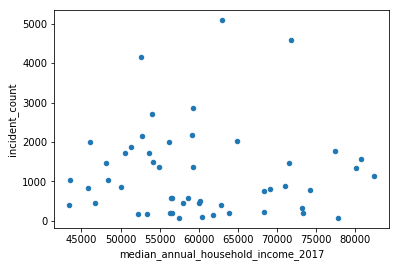

In [36]:
# graphed (median_income && incident_count)
state_incidentCount_medianIncome.plot.scatter('median_annual_household_income_2017', 'incident_count')